In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.environ['HOME_DIR'] = 'drive/MyDrive/hidden-networks'
!pip install -r $HOME_DIR/requirements.txt

import sys
sys.path.append(os.path.join('/content', os.environ['HOME_DIR']))

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.autograd as autograd
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from supermask_pruning import GetSubnet, SupermaskConv, SupermaskLinear
from supermask_pruning import train, test

class ArgClass:
    def __init__(self, args):
        self.setattrs(**args)
        
    def setattrs(self, **kwargs):
        for name, val in kwargs.items():
            setattr(self, name, val)

In [14]:
class Net(nn.Module):
    def __init__(self, args, input_channels, image_size, num_labels):
        super().__init__()
        sparsities = getattr(args, "sparsity", [1.0, 1.0, 1.0, 1.0])
        print(sparsities)
        self.conv1 = SupermaskConv(input_channels, 32, 3, 1, bias=False, init=args.init, **sparsities[0])
        self.conv2 = SupermaskConv(32, 64, 3, 1, bias=False, init=args.init, **sparsities[1])
        s = (image_size - 4) * (image_size - 4) * 64 // 4
        self.fc1 = SupermaskLinear(s, 128, bias=False, init=args.init, **sparsities[2])
        self.fc2 = SupermaskLinear(128, num_labels, bias=False, init=args.init, **sparsities[3])
        self.args = args

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
    def get_extra_state(self):
        return self.args
      
    def set_extra_state(self, state):
        self.args = state

def get_prune_mask(layer, sparsity):
    with torch.no_grad():
        return GetSubnet.apply(layer.scores.abs(), sparsity)

In [18]:
def get_node_relationships(incoming_mask, outgoing_mask):
    assert incoming_mask.shape[0] == outgoing_mask.shape[1]
    return torch.vstack([incoming_mask.sum(dim=1), outgoing_mask.sum(dim=0)]).T 

In [6]:
args = ArgClass({'init': 'signed_constant'})
model = Net(args, 1, 28, 10)
state_dict = torch.load(os.path.join(os.environ["HOME_DIR"], "trained_networks", "22_fc1_sparsity_0.2.pt"), map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
args = model.args
args.init = 'signed_constant'
args.dataset = 'MNIST'
# model.__init__(args, 1, 28, 10)

In [15]:
# The main function runs the full training loop on a dataset of your choice
def main(model_args, train_args, base_model=None, trial=None):
    args = ArgClass(model_args)
    train_args = ArgClass(train_args)
    dataset = args.dataset

    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")
    print(f"Using device {device}")

    transform = None
    if dataset == "MNIST":
        transform = transforms.Compose([transforms.ToTensor(), 
                                        transforms.Normalize((0.1307,), (0.3081,))
                                        ])
        train_transform = transform
        input_channels, image_size, num_labels = 1, 28, 10
    elif dataset == "CIFAR10":
        train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.ToTensor(),
                                              transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                              ])
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                        ])
        input_channels, image_size, num_labels = 3, 32, 10
    else:
        raise ValueError("Only supported datasets are CIFAR10 and MNIST currently.")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        getattr(datasets, dataset)(os.path.join(train_args.data, dataset), 
                                   train=True, download=True, transform=transform),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    train_augmented_loader = torch.utils.data.DataLoader(
        getattr(datasets, dataset)(os.path.join(train_args.data, dataset), 
                                   train=True, transform=train_transform),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        getattr(datasets, dataset)(os.path.join(train_args.data, dataset), 
                                   train=False, transform=transform),
        batch_size=train_args.test_batch_size, shuffle=True, **kwargs)

    model = Net(args, input_channels, image_size, num_labels).to(device)

    if getattr(args, "copy_layers", None) is not None:
        if (bool(args.copy_layers) ^ (base_model is not None)):
            raise ValueError("copy_layers arg must be None or [] if base_model is not specified")
        if base_model is not None and args.copy_layers:
            for layer in args.copy_layers:
                model.load_state_dict(getattr(base_model, layer).state_dict(prefix=f"{layer}."), strict=False)
            
    # NOTE: only pass the parameters where p.requires_grad == True to the optimizer! Important!
    optimizer = getattr(optim, args.optimizer)(
        [p for p in model.parameters() if p.requires_grad],
        **args.optim_kwargs,
    )
    assert isinstance(args.epochs, list) or isinstance(args.epochs, int)
    num_epochs, check_freeze = (args.epochs, False) if isinstance(args.epochs, int) else (max(args.epochs), True)
    criterion = nn.CrossEntropyLoss().to(device)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs) if args.scheduler else None 

    for epoch in range(1, num_epochs + 1):
        if check_freeze:
            for freeze_at_epoch, child in zip(args.epochs, model.children()):
                if freeze_at_epoch == epoch - 1:
                    child.freeze()
                    print(f"Freezing {child} before epoch {epoch}")
        try:
            train(model, train_args.log_interval, device, train_augmented_loader, optimizer, criterion, epoch)
        except Exception as e:
            global failed_model
            failed_model = model
            raise e
        if (train_args.train_eval_interval and epoch % train_args.train_eval_interval == 0) or (train_args.eval_on_last and epoch == args.epochs):
            train_acc, train_loss = test(model, device, criterion, train_loader, name="Train")
            if trial:
                trial.set_user_attr('train_acc', {**trial.user_attrs.get('train_acc', {}), **{epoch: train_acc}})
                trial.set_user_attr('train_loss', {**trial.user_attrs.get('train_loss', {}), **{epoch: train_loss}})
        if (train_args.test_eval_interval and epoch % train_args.test_eval_interval == 0) or (train_args.eval_on_last and epoch == args.epochs):
            test_acc, test_loss = test(model, device, criterion, test_loader, name="Test")
            if trial:
                trial.set_user_attr('test_acc', {**trial.user_attrs.get('test_acc', {}), **{epoch: test_acc}})
                trial.set_user_attr('test_loss', {**trial.user_attrs.get('test_loss', {}), **{epoch: test_loss}})
                trial.report(test_acc, epoch-1)
                if trial.should_prune():
                    raise optuna.exceptions.TrialPruned()

        if scheduler:
            scheduler.step()

    if args.save_name is not None:
        torch.save(model.state_dict(), os.path.join(os.environ['HOME_DIR'], \
                                                    "trained_networks", args.save_name))
    
    return model, device, train_loader, test_loader, criterion

def get_prune_mask(layer, sparsity):
    with torch.no_grad():
        return GetSubnet.apply(layer.scores.abs(), sparsity)

In [28]:
train_args = {
    "test_batch_size": 1000, # input batch size for testing (default: 1000)
    'data': '../data', # Location to store data (e.g. MNIST)
    'log_interval': 500000, # how many batches to wait before logging training status
    'train_eval_interval': 10, # epoch interval at which to print training accuracy
    'test_eval_interval': 10, # epoch interval at which to print test accuracy
    'eval_on_last': True
}

args = {
  "dataset": "MNIST",
  "init": "signed_constant",
  "batch_size": 64, # input batch size for training (default: 64)
  "epochs": [10, 14, 30, 14], # number of epochs to train (default: 14)
  "optimizer": "SGD",
  "optim_kwargs": {"lr": 0.1, "momentum": 0.9, "weight_decay": 0.0001},
  "scheduler": True, # False for Adam, True for SGD, does CosineAnnealing
  'no_cuda': False, # disables CUDA training
  'seed': 1000, # random seed (default: 1)
  'save_name': None, #"conv2_frozen_sp50_rs1000", # "simple20_rs2", # For Saving the current Model, None if not saving
  'sparsity': [{"sparsity": 0.5}, {"sparsity": 0.5}, {"sparsity": 0.2}, {"sparsity": 0.3}], # 'how sparse is each layer'
  'copy_layers': [], # ['conv1', 'conv2', 'fc2'],
  'bias': False
}

model, device, train_loader, test_loader, criterion = main(args, train_args)

Using device cuda
[{'sparsity': 0.5}, {'sparsity': 0.5}, {'sparsity': 0.2}, {'sparsity': 0.3}]
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301356
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.153030
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.074204
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.133528
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.100651
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.065071
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.019382
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.017504
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.062570
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.025420

Test set: Average loss: 0.0001, Accuracy: 9792/10000 (98%)

Freezing SupermaskConv(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False, sparsity=0.5) before epoch 11
Train Epoch: 11 [0/60000 (0%)]	Loss: 0.042079
Train Epoch: 12 [0/60000 (0%)]	Loss: 0.102498
Train Epoch: 13 [0/60000 (0%)]	Loss: 0.027964
Train Epoch: 14 [0/60000 (0%)]	Loss: 0.128716
Freezing SupermaskConv(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False, sparsity=0.5) before epo

In [12]:
failed_model.fc1.main_sparsity

{'sparsity': 0.2}

In [29]:
fc1_mask = get_prune_mask(model.fc1, model.fc1.sparsity)
fc2_mask = get_prune_mask(model.fc2, model.fc2.sparsity)

In [30]:
(points[:, 0][points[:, 1] == 0]).sum()

tensor(84130., device='cuda:0')

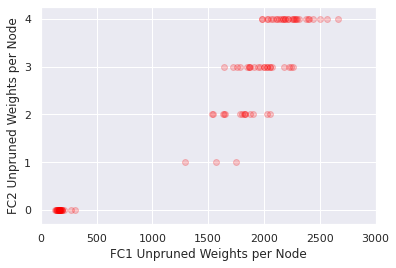

In [40]:
sns.set_theme()
points = get_node_relationships(fc1_mask, fc2_mask)
plt.scatter(points[:, 0].cpu() - 150, points[:, 1].cpu(), alpha=0.2, c='red')
plt.xlabel("FC1 Unpruned Weights per Node")
plt.ylabel("FC2 Unpruned Weights per Node")
plt.yticks([0, 1, 2, 3, 4])
plt.xlim(0, 3000)
plt.ylim(-0.3, 4.25)
plt.savefig(os.path.join(os.environ['HOME_DIR'], 'figures', 'edge_popup_dead_weights.png'), dpi=250, tight_layout=True)

In [ ]:
idx = 22
weights = (fc1_mask[idx] * model.fc1.weight.data[idx])[fc1_mask[idx] != 0] 
locations = torch.where(fc1_mask[idx] > 0)[0]
print((model.fc2.weight.data * get_prune_mask(model.fc2, model.fc2.sparsity))[:, idx])
weights, locations

tensor([-0.0000,  0.2097, -0.0000,  0.0000, -0.0000,  0.0000, -0.1389,  0.0000,
        -0.1820, -0.0000])


(tensor([-0.0173, -0.0164, -0.0238, -0.0167, -0.0232, -0.0305, -0.0209, -0.0199,
         -0.0175, -0.0227, -0.0153, -0.0308, -0.0269, -0.0125, -0.0228, -0.0436,
         -0.0134, -0.0301, -0.0221, -0.0186, -0.0315, -0.0182, -0.0248, -0.0276,
         -0.0218, -0.0322, -0.0190, -0.0173,  0.0169, -0.0251,  0.0258,  0.0285,
         -0.0296,  0.0240,  0.0231, -0.0262, -0.0280, -0.0103, -0.0370, -0.0318,
          0.0185,  0.0225,  0.0269, -0.0290, -0.0248,  0.0150, -0.0151, -0.0438,
         -0.0164,  0.0355, -0.0400, -0.0393, -0.0446, -0.0272,  0.0444, -0.0162,
         -0.0277,  0.0207, -0.0274, -0.0272, -0.0255, -0.0165, -0.0249, -0.0354,
         -0.0215, -0.0229, -0.0234, -0.0385, -0.0221, -0.0254, -0.0179, -0.0144,
         -0.0294, -0.0253, -0.0312, -0.0187, -0.0233, -0.0251, -0.0173, -0.0234,
          0.0233, -0.0139, -0.0262, -0.0392, -0.0187, -0.0154,  0.0207,  0.0249,
         -0.0316, -0.0246, -0.0275, -0.0133, -0.0258, -0.0198,  0.0477, -0.0276,
          0.0242, -0.0300, -

(array([485., 703., 686., 500., 308., 173.,  83.,  40.,  19.,   2.]),
 array([0.00018978, 0.00545155, 0.01071332, 0.01597509, 0.02123686,
        0.02649863, 0.0317604 , 0.03702217, 0.04228394, 0.04754571,
        0.05280748], dtype=float32),
 <a list of 10 Patch objects>)

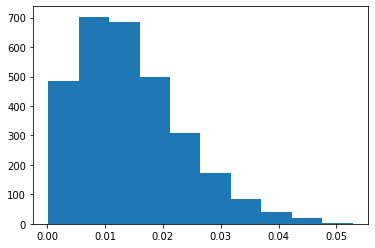

In [ ]:
plt.hist(weights.abs())

In [ ]:
fc2_mask.sum(dim=0)

tensor([1., 0., 0., 3., 0., 0., 0., 1., 0., 2., 0., 0., 0., 2., 0., 3., 3., 1.,
        0., 3., 3., 0., 0., 0., 2., 0., 0., 0., 0., 3., 3., 0., 0., 2., 0., 0.,
        0., 2., 0., 0., 1., 3., 2., 0., 2., 1., 0., 0., 2., 2., 0., 4., 0., 0.,
        2., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 2., 4.,
        0., 0., 4., 0., 0., 0., 3., 0., 4., 0., 0., 4., 2., 0., 3., 0., 0., 2.,
        2., 0., 4., 3., 0., 0., 2., 0., 3., 3., 0., 3., 0., 3., 0., 0., 0., 3.,
        1., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 1., 0., 3., 3., 0., 3.,
        0., 0.])